### Exploring MHD, part 1

To better appreciate the data retrieve, my next step is to lookup these file formats and understand a little bit more how to query them. This is the time where I will review whether there are libraries that are the best at this work. I will post my results below. To appreciate these files, I will install few libraries that will be required later on.

Some libraries required/recommended:
- [simpleITK](https://simpleitk.org/)
- [dask](https://docs.dask.org/en/stable/install.html)

In [1]:
#%pip install pydicom scikit-image plotly SimpleITK ipywidgets
import pydicom
from LUNA16.utils.analyze_folders import analyze_folder
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import plotly
import skimage
import pprint
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, FloatSlider
import SimpleITK as sitk
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 8]
random.seed(123)

To get started with our exploration, we will first pick a random MetaData file, and check if it has any accompanying files in the dataset. 

In [2]:
ROOT_FOLDER = "/home/azureuser/cloudfiles/data/LUNA16/extracted"
all_files = analyze_folder(ROOT_FOLDER)
random_uid = random.choice([file.filename for file in all_files if file.extension =="mhd"])
print(f"The Random UID chosen for this notebook is: {random_uid}")
notebook_files = [file for file in all_files if file.filename ==random_uid]
print(f"There were {len(notebook_files)} files found with this uid., they are:\nSize \t Ext. \t Folder.")
for file in notebook_files:
    print(round(file.size / (1024 **2), 4), "\t", file.extension, "\t", file.folder.split("/")[-2])
raw = [file for file in notebook_files if file.extension == "raw"][0]
mhd = [file for file in notebook_files if file.extension == "mhd"]

The Random UID chosen for this notebook is: 1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058
There were 3 files found with this uid., they are:
Size 	 Ext. 	 Folder.
120.0 	 raw 	 subset4
0.0004 	 mhd 	 subset4
0.0005 	 mhd 	 seg-lungs-LUNA16


Out of curiosity, I think it would be interesting to visualize our randomly picked UID. to do so:
1. We open the file
2. Change the order of the axes to represent H, W, C isntead of C, H, W
3. Create a subplots and display each

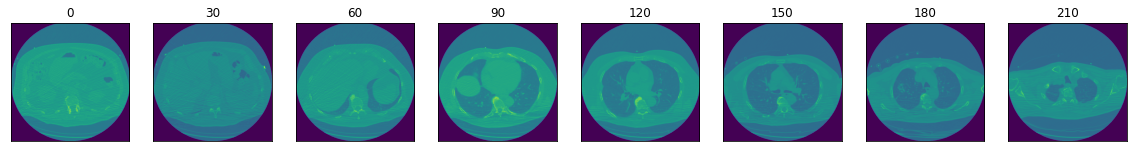

In [3]:
mhd_image = sitk.ReadImage(mhd[0].folder)
mhd_image = np.array(sitk.GetArrayFromImage(mhd_image), dtype=np.float32)
mhd_image = np.transpose(mhd_image, [1, 2, 0])
NUM_IMAGES = 8
fig, ax = plt.subplots(1, NUM_IMAGES)
for i in range(NUM_IMAGES):
    spacing = round(mhd_image.shape[2] / NUM_IMAGES)
    idx = i * spacing
    image = mhd_image[:,:,idx]
    ax[i].imshow(image)
    ax[i].set_title(f"{idx}")
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
plt.show()
plt.close()

Those cross-sections are very interesting!!! I admit that I still don't understand the syntax of ```SimpleITK``` but we are progressing forward. One area that I would like to know about is the distribution of values within the slides of the image. This is what we explore next. The first implementation we make is sequential and does not leverage multiprocessing. it is long and has been commented.

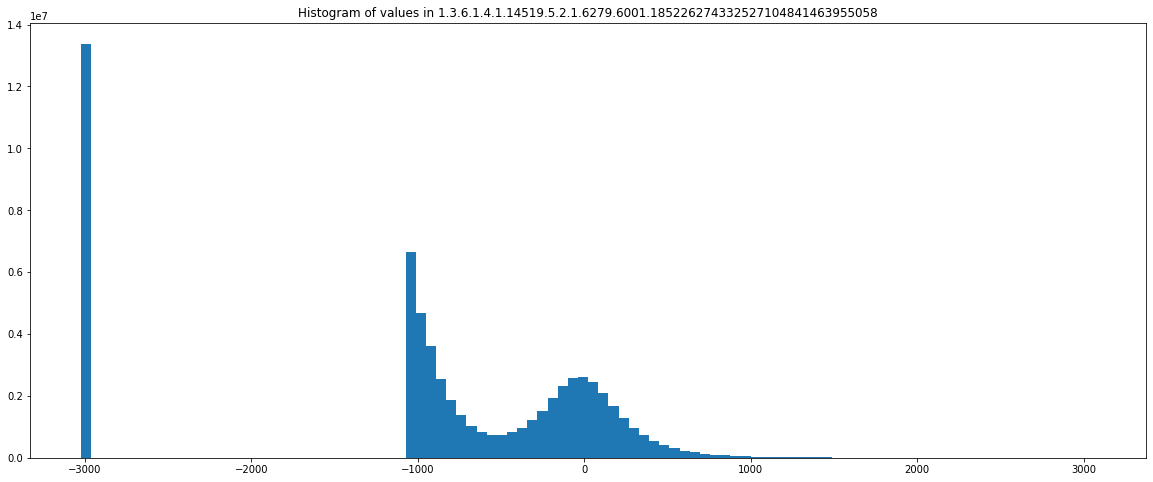

In [4]:
hist_data = np.reshape(mhd_image, -1) #Flatten all channels
plt.hist(hist_data, bins=100)
plt.title(f"Histogram of values in {mhd[0].filename}")
plt.show()

We realize that some values seem to be improperly computed - why are there so many values at -3000? This is worth investigating.
To do so, I will start creating reusable objects in the ```LUNA16``` package.

My first experimentation is to open all the mhd files, and try to understand the distribution of data. But first, we need to make sure that we using the multiprocessing package correctly to perform fast calculations. I will first try to run a process sequentially, and then use multiprocessing.

In [5]:
from LUNA16.utils.analyze_data_distribution import analyze_data_distribution, analyze_shapes
from tqdm.notebook import tqdm
from collections import Counter

all_mhd_files = [file for file in all_files if file.extension == "mhd"]
all_results = []

# Uncomment to perform sequential operation. It took 11 minutes on my machine, Your mileage may vary.
# for i in tqdm(range(len(all_mhd_files))):
#     result = analyze_shapes([all_mhd_files[i]])
#     all_results.append(result)
# shapes = Counter(all_results)
# print(shapes.most_common(10))

In [6]:
import multiprocessing
all_mhd_files_mp = [(file, ) for file in all_files if file.extension == "mhd"]

def mp_fn(fn, files,):
    PROCESSES = multiprocessing.cpu_count() * 2
    with multiprocessing.Pool(PROCESSES) as pool:
        pool_results = pool.map(fn, files)

    return pool_results

In [7]:
# Takes approximately 4 minutes to compute with parallel processing
output = mp_fn(analyze_shapes, all_mhd_files_mp)

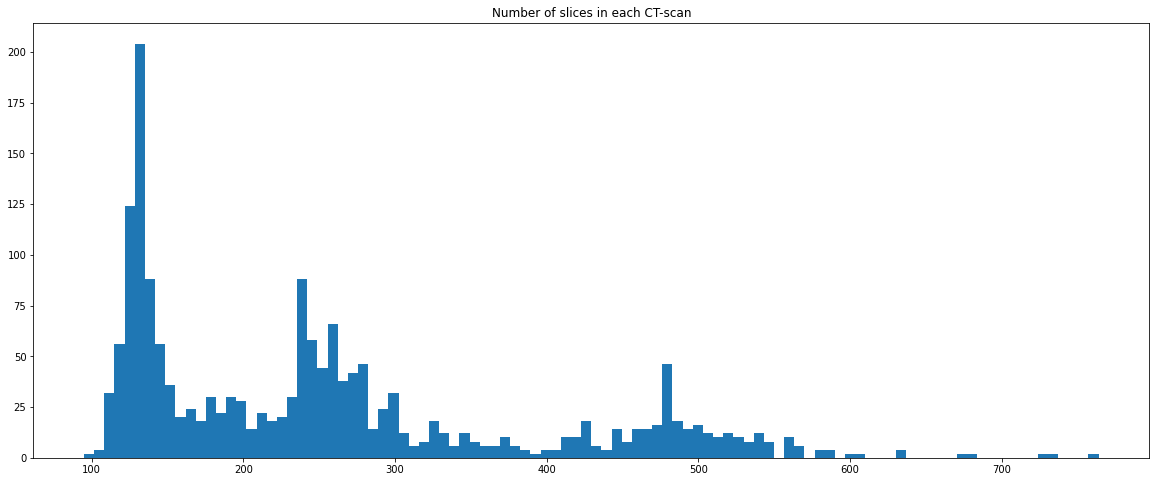

In [8]:
plt.hist(output, bins=100)
plt.title("Number of slices in each CT-scan")
plt.show()

In [10]:
print(f"In total there are {sum(output)} channels. - This will be handy for the next notebook.")

In total there are 454450 channels. - This will be handy for the next notebook.


At this stage, we will move to the next notebook to evaluate using Dask to process the massive amount of data

WIP WIP WIP


I now turn my attention to exploring the RAW file, as well as the pydicom library.
First, considering the ```pydicom``` library is one that I am not very familiar with, I decide to browse the contents of this namespace. to do so, I use list comprehension to onlypretty print those contents of ```__dir__``` if they dont include an underscore. After analyzing the returned commands, I believe that ```.dcmread()``` seems to be what I need to open the file.